In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
all_labels = pd.read_csv('../data/train_labels_all.csv')

In [3]:
# Get the id's of the files we sampled
sampled_images = os.listdir('../data/train_sample/')

In [4]:
filtered_data = all_labels[all_labels.ImageId.isin(sampled_images)]

In [6]:
filtered_data.head()

,ImageId,EncodedPixels
18,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...
19,0002756f7.jpg,248878 1 249645 4 250413 6 251180 9 251948 10 ...
84,0016ae695.jpg,NaN
92,00189cc36.jpg,NaN
100,001a7cba8.jpg,NaN


In [24]:
def code2image(encoding, input_image):
    if pd.isnull(encoding):
        return input_image
    
    else:
        split_encoding = encoding.split()
        n_pixels = int(len(split_encoding)/2)
        
        # pixels are 1 indexed in order 1: (1,1), 2: (2,1), etc. 
        # see: https://www.kaggle.com/c/airbus-ship-detection#evaluation
        flatten_image = input_image.flatten('F')
        
        for pixel_idx in range(n_pixels):
            row_numb = int(split_encoding[pixel_idx*2])
            mask_len = int(split_encoding[pixel_idx*2 + 1])
            
            flatten_image[row_numb:row_numb+mask_len] = 1
            
        return np.reshape(flatten_image, newshape = (768, 768), order='F')

In [7]:
name = '3c74edc8e.jpg'

In [10]:
filtered_data[filtered_data.ImageId==name]

,ImageId,EncodedPixels
54378,3c74edc8e.jpg,514581 4 515341 12 516105 16 516873 16 517641 ...
54379,3c74edc8e.jpg,328114 3 328876 9 329639 14 330404 18 331172 1...
54380,3c74edc8e.jpg,407871 18 408639 18 409407 18 410175 18 410943...
54381,3c74edc8e.jpg,534773 12 535530 23 536298 23 537066 23 537834...
54382,3c74edc8e.jpg,388264 5 389023 14 389783 22 390546 27 391314 ...
54383,3c74edc8e.jpg,438629 4 439394 7 440162 7 440930 7 441698 8 4...
54384,3c74edc8e.jpg,440303 4 441064 11 441828 15 442596 16 443364 ...
54385,3c74edc8e.jpg,342880 5 343640 13 344404 17 345172 17 345940 ...


248878 1 249645 4 250413 6 251180 9 251948 10 252715 13 253482 16 254250 18 255019 18 255789 18 256559 18 257329 18 258099 17 258869 15 259639 12 260409 10 261179 7 261949 5 262719 2 263488 1 264255 1
219.0


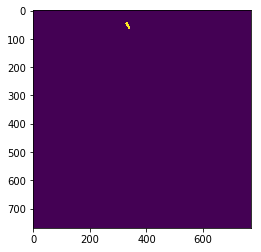

In [32]:
test_row = filtered_data.EncodedPixels.iloc[1]
print(test_row)
test_image = np.zeros((768, 768))
out_arr = code2image(test_row, test_image)
print(sum(sum(out_arr)))
plt.imshow(out_arr)
plt.show()

In [109]:
grouped_dat = filtered_data.groupby('ImageId')

In [50]:
import imageio

In [53]:
for group, rows in grouped_dat:
    
    image = np.zeros((768, 768))
    for index, row in rows.iterrows():
        image = code2image(row['EncodedPixels'], image)
    
    imageio.imwrite('../DeepBlueSea/data/train_maps/gt_'+group, 255*image)

/Users/brianregan/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/Users/brianregan/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


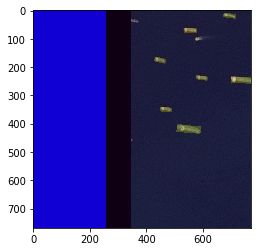

In [72]:
# View Some Examples 
name = '3c74edc8e.jpg'
train_image = imageio.imread('../DeepBlueSea/data/train_sample/' + name)
gt_map = image = imageio.imread('../DeepBlueSea/data/train_maps/gt_' + name)
plt.imshow(train_image)
plt.imshow(gt_map, alpha = 0.25)
plt.show()

In [140]:
def code2box(encoding, label):
    if pd.isnull(encoding):
        return [label,np.asarray([0,0]), 0, 0]
    else:
        split_encoding = encoding.split()
        n_pixels = int(len(split_encoding)/2)
        
        # pixels are 1 indexed in order 1: (1,1), 2: (2,1), etc. 
        # see: https://www.kaggle.com/c/airbus-ship-detection#evaluation
        input_image = np.zeros((768, 768))
        flatten_image = input_image.flatten('F')
        
        for pixel_idx in range(n_pixels):
            row_numb = int(split_encoding[pixel_idx*2])
            mask_len = int(split_encoding[pixel_idx*2 + 1])
            
            flatten_image[row_numb:row_numb+mask_len] = 1
        input_image = np.reshape(flatten_image, newshape = (768, 768), order='F')
        xaxis, yaxis = np.nonzero(input_image)
        corner = np.asarray([0,0])
        corner[0] = np.min(xaxis)
        corner[1] = np.min(yaxis)
        height = np.max(yaxis) - corner[1]
        width = np.max(xaxis) - corner[0]
        return [label, corner, width, height]

In [150]:
#output = np.empty((len(all_labels),2))
output = [code2box(row['EncodedPixels'],row['ImageId']) for index, row in all_labels.iterrows()]
#df = all_labels.head(5)
#output = [ code2box(row['EncodedPixels'],row['ImageId']) for index, row in df.iterrows()]

In [151]:
df_out = pd.DataFrame(output, columns=['ImageId','corner', 'width', 'height'])

In [154]:
df_out.head()
path = "/Users/margheritarosnati/Documents/DS/2018-2/DL/DeepBlueSea/data/train_maps/boxes.pkl"
df_out.to_pickle(path)